### TODO

- Parameterize EVT (must first instantiate EVT pckg)
- Parameterize Reach 1 inflow
- Parameterize Lumprem models
- Covariance matrices

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import flopy
from flopy.utils.gridintersect import GridIntersect
#import pyemu

from shapely.geometry import Polygon, Point
import shapefile
from shapely.prepared import prep

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'font.size': 14})

In [2]:
bins_pth = os.path.join('..', 'bins', 'win') if 'nt' in os.name else os.path.join('..', 'bins', 'linux') # Binaries
shapefile_pth = os.path.join('..', 'data', 'raw_data', 'shapefiles')
observations_pth = os.path.join('..', 'data', 'observations') # Measured data (field obs)

In [3]:
org_model_ws = os.path.join('..', 'temp_flopy_lumprem')
os.listdir(org_model_ws)

['ghbpp.dat',
 'ghbpp.tpl',
 'ghb_new.ts',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sfr.obs',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'head.obs.csv',
 'lr_blueviolet.tpl',
 'lr_limegreen.tpl',
 'lr_lu1.tpl',
 'lr_magenta.tpl',
 'lr_orange.tpl',
 'lr_red.tpl',
 'lr_royalblue.tpl',
 'lr_yellow.tpl',
 'mfsim.lst',
 'mfsim.nam',
 'rch_new.ts',
 'sfr_gage.obs.csv',
 'sfr_leak.obs.csv',
 'sfr_pred_leak.obs.csv',
 'sfr_pred_outfr1.obs.csv',
 'sfr_segfile.dat',
 'sfr_stage.obs.csv']

Setup directory structure:

In [4]:
model_root = os.path.join('..', 'temp_ml_param')

runmodel_ws = os.path.join(model_root, 'runmodel')
model_ws = os.path.join(runmodel_ws, 'model')
preproc_ws = os.path.join(runmodel_ws, 'preproc')
lumprem_ws = os.path.join(runmodel_ws, 'lumprem')

pest_ws = os.path.join(model_root, 'pest')
template_ws = os.path.join(pest_ws, 'template')
instruction_ws = os.path.join(pest_ws, 'instruction')

In [5]:
dir_lvl1 = [runmodel_ws, pest_ws]
dir_lvl2 = [model_ws, preproc_ws, lumprem_ws, template_ws, instruction_ws]

In [11]:
if os.path.exists(model_root):
    shutil.rmtree(model_root)

os.mkdir(model_root)

In [12]:
for pth in dir_lvl1:
    os.mkdir(pth)
for pth in dir_lvl2:
    os.mkdir(pth)

In [13]:
shutil.copytree(org_model_ws,model_ws, dirs_exist_ok=True)
os.listdir(model_ws)

['ghbpp.dat',
 'ghbpp.tpl',
 'ghb_new.ts',
 'hagfors_1.cbb',
 'hagfors_1.disv',
 'hagfors_1.disv.grb',
 'hagfors_1.ghb',
 'hagfors_1.hds',
 'hagfors_1.ic',
 'hagfors_1.ims',
 'hagfors_1.lst',
 'hagfors_1.nam',
 'hagfors_1.npf',
 'hagfors_1.obs',
 'hagfors_1.oc',
 'hagfors_1.rch',
 'hagfors_1.sfr',
 'hagfors_1.sfr.bud',
 'hagfors_1.sfr.obs',
 'hagfors_1.sto',
 'hagfors_1.tdis',
 'head.obs.csv',
 'lr_blueviolet.tpl',
 'lr_limegreen.tpl',
 'lr_lu1.tpl',
 'lr_magenta.tpl',
 'lr_orange.tpl',
 'lr_red.tpl',
 'lr_royalblue.tpl',
 'lr_yellow.tpl',
 'mfsim.lst',
 'mfsim.nam',
 'rch_new.ts',
 'sfr_gage.obs.csv',
 'sfr_leak.obs.csv',
 'sfr_pred_leak.obs.csv',
 'sfr_pred_outfr1.obs.csv',
 'sfr_segfile.dat',
 'sfr_stage.obs.csv']

Move all the LUMPREM template files to `template_ws` and SEGLIST files to `preproc_ws` directories:

In [14]:
def move_files(old_pth, new_pth, file):
    from_ = os.path.join(old_pth, file)
    to_ = os.path.join(new_pth, file)
    shutil.move(from_, to_)

In [15]:
lr_tpls = [i for i in os.listdir(model_ws) if '.tpl' in i]

In [16]:
for file in lr_tpls:
    move_files(model_ws, template_ws, file)

In [17]:
move_files(model_ws, preproc_ws, 'sfr_segfile.dat')
move_files(model_ws, preproc_ws, 'ghbpp.dat')

Move all the LUMPREM input files to `lumprem_ws`:

In [18]:
lr_prep_pth = os.path.join('..', 'temp_lr_prep')

In [19]:
os.listdir(lr_prep_pth)

['evapot.dat',
 'ghb.ts',
 'ghb.ts.in',
 'lr_blueviolet.csv',
 'lr_blueviolet.in',
 'lr_blueviolet.out',
 'lr_limegreen.csv',
 'lr_limegreen.in',
 'lr_limegreen.out',
 'lr_lu1.csv',
 'lr_lu1.in',
 'lr_lu1.out',
 'lr_magenta.csv',
 'lr_magenta.in',
 'lr_magenta.out',
 'lr_orange.csv',
 'lr_orange.in',
 'lr_orange.out',
 'lr_red.csv',
 'lr_red.in',
 'lr_red.out',
 'lr_royalblue.csv',
 'lr_royalblue.in',
 'lr_royalblue.out',
 'lr_yellow.csv',
 'lr_yellow.in',
 'lr_yellow.out',
 'lumprem_variables.rec',
 'rainfall.dat',
 'rch.ts',
 'rch.ts.in',
 'ts6ghb.in',
 'ts6rch.in']

In [20]:
for file in os.listdir(lr_prep_pth):
    shutil.copyfile(os.path.join(lr_prep_pth, file), os.path.join(lumprem_ws, file))

In [21]:
os.listdir(lumprem_ws)

['evapot.dat',
 'ghb.ts',
 'ghb.ts.in',
 'lr_blueviolet.csv',
 'lr_blueviolet.in',
 'lr_blueviolet.out',
 'lr_limegreen.csv',
 'lr_limegreen.in',
 'lr_limegreen.out',
 'lr_lu1.csv',
 'lr_lu1.in',
 'lr_lu1.out',
 'lr_magenta.csv',
 'lr_magenta.in',
 'lr_magenta.out',
 'lr_orange.csv',
 'lr_orange.in',
 'lr_orange.out',
 'lr_red.csv',
 'lr_red.in',
 'lr_red.out',
 'lr_royalblue.csv',
 'lr_royalblue.in',
 'lr_royalblue.out',
 'lr_yellow.csv',
 'lr_yellow.in',
 'lr_yellow.out',
 'lumprem_variables.rec',
 'rainfall.dat',
 'rch.ts',
 'rch.ts.in',
 'ts6ghb.in',
 'ts6rch.in']

START

In [22]:
ml_name = 'hagfors_1'

In [23]:
sim = flopy.mf6.MFSimulation.load(ml_name, 'mf6', os.path.join(bins_pth, 'mf6'), model_ws)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package disv...
    loading package rch...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package sto...
    loading package sfr...
    loading package obs...
    loading package ghb...
  loading ims package hagfors_1...


Set all data external so that PEST can adjust parameter values during history matching:

In [24]:
sim.set_all_data_external(True)

In [25]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package hagfors_1...
  writing model hagfors_1...
    writing model name file...
    writing package disv...
    writing package rch_ts...
    writing package rch...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package sto...
    writing package sfr_obs...
    writing package sfr...
    writing package gwf_obs...
    writing package ghb_ts...
    writing package ghb...


In [26]:
gwf = sim.get_model(ml_name)

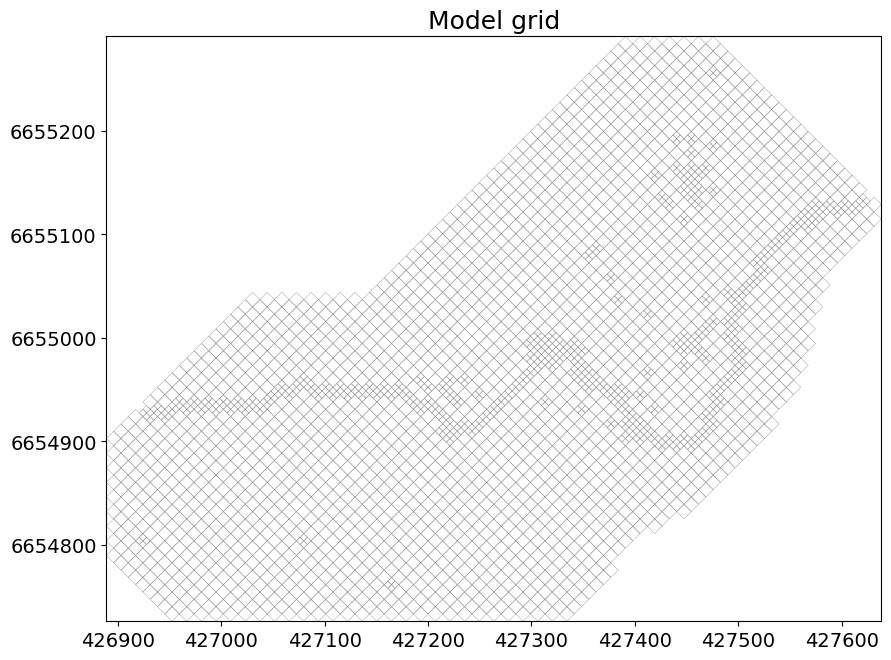

In [27]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Model grid', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

plt.show()

## Generate pilot points
3D-pilot points will be generated for the following areal properties:
- SY & SS (perhaps SS could be skipped?)
- Porosity and possibly diffusion/dispersion and any other parameter needed to represent transport
- Kh and Kz

In addition, pilot points will be generated along the following linear features:
- Streambed hydraulic conductivity along Creek Örbäcken (SFR package)
- GHB conductance

### 3D pilot points
Because we want to do a data-worth analysis, we should consider the total amount of pilot points to be employed to find a suitable compromise between adjustable parameters and model run-time.

For this reason, we will create different sets of pilot points for each parameter type (in order to not use an exessive amount of pps).

Sy, SS and possibly porosity (along with other parameters that govern transport) could be parameterized using a coarser pp-spacing, so let's start with that.

However, before we start, let's import the observation locations, so that we can see how the pilot points will be located in relation to them:

In [28]:
sfr_obs = pd.read_excel(os.path.join(observations_pth, 'obs_flow_and_stage.xlsx'))
head_obs = pd.read_excel(os.path.join(observations_pth, 'obs_head_per_layer.xlsx')).drop_duplicates(subset=['POINT_X', 'POINT_Y'])
head_obs['TYPE'] = 'HEAD'

In [29]:
obs_points = pd.concat([head_obs, sfr_obs])
display(obs_points)

,NAME,POINT_X,POINT_Y,LAYER,TYPE
0,B9-2,426918.374000,6.654803e+06,1.0,HEAD
1,B10-2,427074.709423,6.654805e+06,1.0,HEAD
2,B12-1,427448.188505,6.655156e+06,1.0,HEAD
3,B16-1,427409.547301,6.655023e+06,1.0,HEAD
4,B2-1,427384.172044,6.655037e+06,1.0,HEAD
...,...,...,...,...,...
2,NI15-O46-STG,427316.293421,6.655000e+06,NaN,STAGE
3,NI15-O47-STG,427294.946661,6.654962e+06,NaN,STAGE
4,NI15-O48-STG,427166.670722,6.654947e+06,NaN,STAGE
5,GAGE-1,427070.614000,6.654949e+06,NaN,INFLOW


#### Coarse 3D pilot points
Let's create the coarse pilot point distribution:

In [30]:
ml_boundary = shapefile.Reader(os.path.join(shapefile_pth, 'model_boundary.shp')) # Model boundary shapefile
mlb_shape = np.array(np.rint(ml_boundary.shapeRecords()[0].shape.points)) # Model boundary array

Instantiate a shapely polygon of the model boundary:

In [31]:
mlb_shapely = Polygon(mlb_shape)

Create prepared polygon of the model boundary:

In [32]:
#mlb_shapely_prep = prep(mlb_shapely.buffer(50)) buffer cause an issue because the grid can't be sampled outside the model boundary
mlb_shapely_prep = prep(mlb_shapely)

Construct a rectangular mesh of points:

In [33]:
xmin, xmax, ymin, ymax = 426900, 427700, 6654650, 6655350 # These are the same coordinates used to construct the base-grid
resolution = 30 # Equal space (in meters) between pilot points
basepoints = []
for lat in np.arange(xmin, xmax, resolution):
    for lon in np.arange(ymin, ymax, resolution):
        basepoints.append(Point((round(lat,4), round(lon,4))))

Use the shapely `contains` (point-in-polygon method) to select points inside the model boundary (increase the number of pps once workflow is confirmed working):

In [34]:
basepip = [] # Basepoints in polygon
for point in basepoints:
    if mlb_shapely_prep.contains(point):
        basepip.append(point)
print(f'Number of points per layer: {len(basepip)}') # We need to extend it into three dimensions

Number of points per layer: 267


Plot the position of the pilot points on top of the model grid:

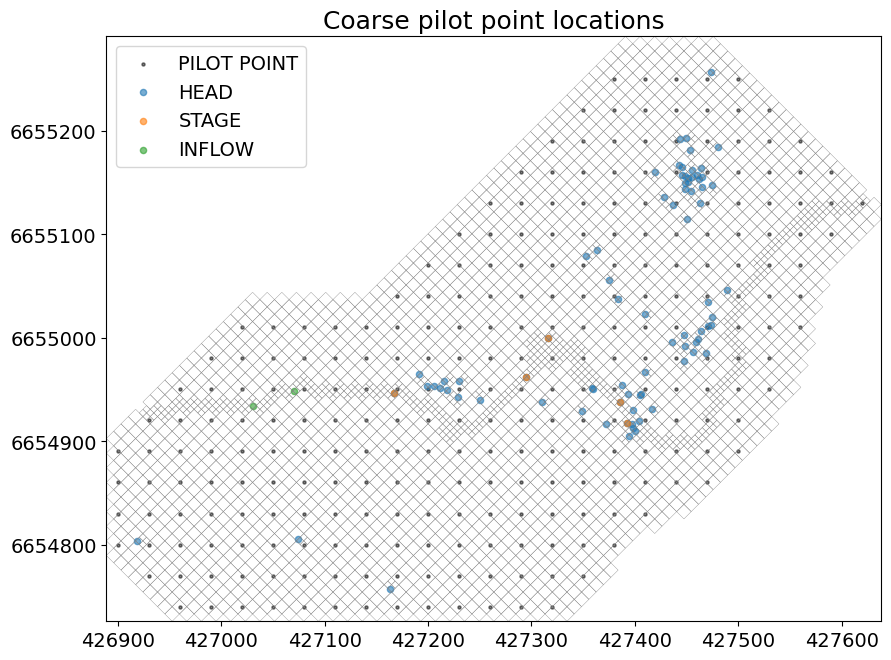

In [35]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('Coarse pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

x = np.array([i.coords[0] for i in basepip])[:,0]
y = np.array([i.coords[0] for i in basepip])[:,1]
plt.scatter(x, y, s=5, c='black', alpha=0.5, label='PILOT POINT')

for category in obs_points['TYPE'].unique():
    x = obs_points.loc[obs_points['TYPE'] == category]['POINT_X']
    y = obs_points.loc[obs_points['TYPE'] == category]['POINT_Y']
    ax.scatter(x, y, s=20, alpha=0.6, label=category)
    
plt.legend()
plt.show()

These points now need to be assigned a z-value, since we are going to use 3D-pilot points. To do this, we will need to intersect the model grid and retrieve the z-values of each layer, so that a copy of these pps can be positioned in each of the three layers:

In [36]:
ix = GridIntersect(gwf.modelgrid)

c:\users\nat12nho\appdata\local\programs\python\python38\lib\site-packages\flopy\utils\gridintersect.py:317: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.name = icell


In [37]:
pp_intersect = {
    'cellids': [],
    'vertices': [],
    'ixshapes': [],
}
for point in basepip:
    pp_intersect['cellids'].append(ix.intersect(point).cellids[0])
    pp_intersect['vertices'].append(ix.intersect(point).vertices[0])
    pp_intersect['ixshapes'].append(ix.intersect(point).ixshapes[0])

In [38]:
pp_intersect = pd.DataFrame(pp_intersect)
display(pp_intersect)

,cellids,vertices,ixshapes
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800)
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830)
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860)
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890)
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770)
...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190)
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100)
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130)
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160)


We can see that the order is respected:

In [39]:
[i.coords[0] for i in basepip][:5]

[(426900.0, 6654800.0),
 (426900.0, 6654830.0),
 (426900.0, 6654860.0),
 (426900.0, 6654890.0),
 (426930.0, 6654770.0)]

Let's use the cellids to sample pilot point elevations (**this takes about 2 minutes on my laptop for 295 cells** and could/should probably be speed up somehow - considering it has to be done for top, botm1, botm2 and botm3):

In [40]:
def get_grid_elevation(elevation_array, index_array):
    '''
    returns list of elevations
    '''
    
    elevations = list(elevation_array)
    indices = list(index_array)
    
    return [elevation_array[i] for i in index_array]

In [41]:
pp_intersect['top'] = get_grid_elevation(elevation_array = gwf.modelgrid.top, index_array=pp_intersect['cellids'])

In [42]:
pp_intersect['botm_1'] = get_grid_elevation(gwf.modelgrid.botm[0], pp_intersect['cellids'])
pp_intersect['botm_2'] = get_grid_elevation(gwf.modelgrid.botm[1], pp_intersect['cellids'])
pp_intersect['botm_3'] = get_grid_elevation(gwf.modelgrid.botm[2], pp_intersect['cellids'])

In [43]:
pp_intersect

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830),136.330093,124.304199,119.473198,117.513603
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860),136.800598,125.293098,120.813400,118.661400
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890),137.616699,126.236198,121.958702,119.823601
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770),135.541397,123.152000,118.293098,115.931099
...,...,...,...,...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190),155.324707,140.380096,137.393005,135.419205
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100),146.750107,139.275497,136.379303,134.998505
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130),143.478104,139.465393,136.847900,135.460999
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160),152.567307,139.972504,137.633301,135.983704


Create pps in-between the layer boundaries (i.e. vertically centered in the cells):

In [44]:
pp_intersect['pps_l1'] = (pp_intersect['top'] + pp_intersect['botm_1']) / 2

In [45]:
pp_intersect['pps_l2'] = (pp_intersect['botm_1'] + pp_intersect['botm_2']) / 2

In [46]:
pp_intersect['pps_l3'] = (pp_intersect['botm_2'] + pp_intersect['botm_3']) / 2

In [47]:
display(pp_intersect)

,cellids,vertices,ixshapes,top,botm_1,botm_2,botm_3,pps_l1,pps_l2,pps_l3
0,263,"((426900.0, 6654800.0),)",POINT (426900 6654800),135.587494,123.422600,118.517899,116.072601,129.505047,120.970249,117.295250
1,148,"((426900.0, 6654830.0),)",POINT (426900 6654830),136.330093,124.304199,119.473198,117.513603,130.317146,121.888699,118.493401
2,82,"((426900.0, 6654860.0),)",POINT (426900 6654860),136.800598,125.293098,120.813400,118.661400,131.046848,123.053249,119.737400
3,21,"((426900.0, 6654890.0),)",POINT (426900 6654890),137.616699,126.236198,121.958702,119.823601,131.926449,124.097450,120.891151
4,586,"((426930.0, 6654770.0),)",POINT (426930 6654770),135.541397,123.152000,118.293098,115.931099,129.346699,120.722549,117.112099
...,...,...,...,...,...,...,...,...,...,...
262,1992,"((427560.0, 6655190.0),)",POINT (427560 6655190),155.324707,140.380096,137.393005,135.419205,147.852402,138.886551,136.406105
263,2657,"((427590.0, 6655100.0),)",POINT (427590 6655100),146.750107,139.275497,136.379303,134.998505,143.012802,137.827400,135.688904
264,2492,"((427590.0, 6655130.0),)",POINT (427590 6655130),143.478104,139.465393,136.847900,135.460999,141.471748,138.156647,136.154449
265,2279,"((427590.0, 6655160.0),)",POINT (427590 6655160),152.567307,139.972504,137.633301,135.983704,146.269905,138.802902,136.808502


Add x, y and clean up df:

In [48]:
pp_intersect['x'] = np.array([i.coords[0] for i in basepip])[:,0]
pp_intersect['y'] = np.array([i.coords[0] for i in basepip])[:,1]

In [49]:
pp_intersect = pp_intersect[['x', 'y', 'pps_l1', 'pps_l2', 'pps_l3']]

In [50]:
pp_intersect

,x,y,pps_l1,pps_l2,pps_l3
0,426900.0,6654800.0,129.505047,120.970249,117.295250
1,426900.0,6654830.0,130.317146,121.888699,118.493401
2,426900.0,6654860.0,131.046848,123.053249,119.737400
3,426900.0,6654890.0,131.926449,124.097450,120.891151
4,426930.0,6654770.0,129.346699,120.722549,117.112099
...,...,...,...,...,...
262,427560.0,6655190.0,147.852402,138.886551,136.406105
263,427590.0,6655100.0,143.012802,137.827400,135.688904
264,427590.0,6655130.0,141.471748,138.156647,136.154449
265,427590.0,6655160.0,146.269905,138.802902,136.808502


Visualize

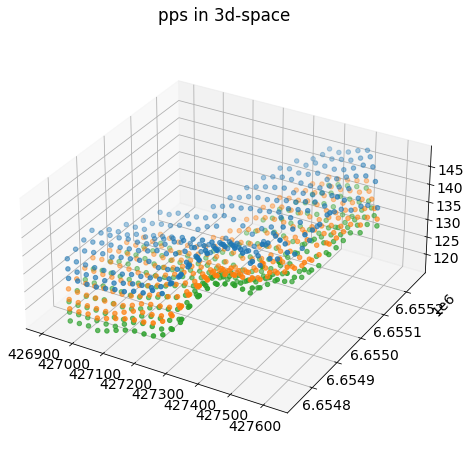

In [51]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_intersect.x.values, pp_intersect.y.values

ax.scatter(x, y, pp_intersect.pps_l1.values)
ax.scatter(x, y, pp_intersect.pps_l2.values)
ax.scatter(x, y, pp_intersect.pps_l3.values)
plt.title('pps in 3d-space')
pyplot.show()

Convert the dataframe into a 3d pilot point file format:

In [52]:
pp_coarse3d = pd.melt(pp_intersect, id_vars=['x', 'y'], value_vars=['pps_l1', 'pps_l2', 'pps_l3'])

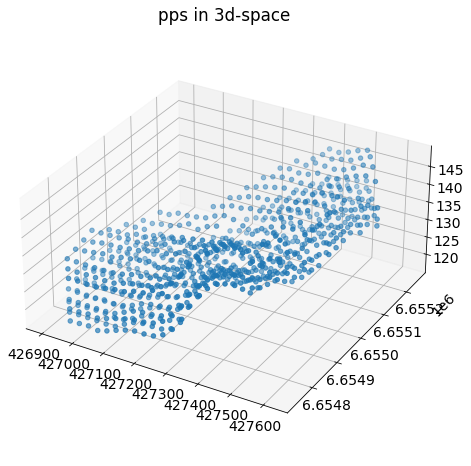

In [53]:
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
import random

fig = pyplot.figure(figsize=(6,6))
ax = Axes3D(fig)
ax.set_box_aspect([2,2,1])

x, y = pp_coarse3d.x.values, pp_coarse3d.y.values

ax.scatter(x, y, pp_coarse3d.value.values)
plt.title('pps in 3d-space')
pyplot.show()

Insert columns:

In [54]:
pp_coarse3d['name'] = [f'ppc{i:04d}' for i in pp_coarse3d.index.values] # ppc = pilot point coarse.

In [55]:
pp_coarse3d[['zone','val']] = 1, 1
pp_coarse3d['z'] = pp_coarse3d['value']

In [56]:
pp_coarse3d['layer'] = [int(i[-1]) for i in pp_coarse3d['variable']]

In [57]:
pp_coarse3d = pp_coarse3d[['name', 'x', 'y', 'z', 'zone', 'val', 'layer']]

In [58]:
display(pp_coarse3d)

,name,x,y,z,zone,val,layer
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1
...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3


In [59]:
from lumpyrem import run
#MKPPSTAT
# mkppstat requires no headers in ppoint file ...sigh...
pp_coarse3d.to_csv(os.path.join(preproc_ws, 'mkppoints3d_coarse.dat'),
                       header=None, index=False, sep='\t')

In [60]:
# Input for MKPPSTAT
# A (a)-factor of 1.5 is often reasonable. from tutorial 
npoints_h, npoints_v = 10, 10 # np-horizontal, np-vertical
a_h, a_v = 1.2, 1.2 # a-horizontal, a-vertical
# run MKPPSTAT
run.run_process(
    'mkppstat3d',
    path=preproc_ws,
    commands=['mkppoints3d_coarse.dat', npoints_h, a_h, npoints_v, a_v, 'ppstat3d_coarse.dat']
)

 
 Program MKPPSTAT3D writes a pilot points statistical specification file 
   based on a 3D pilot points file using local pilot point density to set 
   local variogram range.
 
 Enter name of 3D pilot points file:   - data for 801 pilot points read from pilot points file 
    mkppoints3d_coarse.dat
 
 Enter no. of pilot points to compute local ave. hor. pp. sepn.:  Enter factor of ave. hor. sepn. for local variogram hor. "a" value: 
 Enter no. of pilot points to compute local ave. vert. pp. sepn.:  Enter factor of ave. vert. sepn. for local variogram vert. "a" value: 
 Enter name for 3D pilot point statistical spec. file:  - file ppstat3d_coarse.dat written ok
 



In [61]:
# run PPCOV3D_SVA - pilot point covariance 3d - spatially varying anisotropy
run.run_process(
    'ppcov3d_sva',
    path=preproc_ws,
    commands=['ppstat3d_coarse.dat', 'y', 1, 'x',  'cov3d_coarse.mat', '']
)

 
 Program PPCOV3D_SVA creates a covariance matrix file for 3D pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of 3D pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 801 pilot points read from file ppstat3d_coarse.dat
 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]:  Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter names (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov3d_coarse.mat written ok.



In [62]:
# Load cov mat file with Pyemu for further processing
import pyemu
covmat_coarse = pyemu.Cov.from_ascii(os.path.join(preproc_ws, "cov3d_coarse.mat"))

# This covaraince matrix can now be used as the base for all pilot point parameters. 
# Note that in this case the variance is 1, so it is easy to scale to a parameters prior varaince
# Depending on how you setup the scrpt, variance can be assigned at various stages (i.e. when running PPCOV_SVA, or by manipulating the matrix later)
# Note that parameter names (headers and row names) come from the parameter name sin the ppoint file. These can have a prefix added by PPCOV_SVA, or changed in the dataframe. The latter is more versatile.
covmat_coarse.to_dataframe().head()

,ppc0000,ppc0001,ppc0002,ppc0003,ppc0004,ppc0005,ppc0006,ppc0007,ppc0008,ppc0009,...,ppc0791,ppc0792,ppc0793,ppc0794,ppc0795,ppc0796,ppc0797,ppc0798,ppc0799,ppc0800
ppc0000,1.000000,0.351344,0.123454,0.058025,0.263136,0.352832,0.227973,0.095991,0.036231,0.020228,...,2.540665e-11,1.738932e-11,1.149566e-11,7.339267e-12,4.548162e-12,3.287491e-11,5.076260e-11,2.840003e-12,2.242443e-11,1.483235e-11
ppc0001,0.351344,1.000000,0.351516,0.123462,0.097101,0.227802,0.352695,0.227784,0.095927,0.037066,...,3.566945e-11,2.541688e-11,1.744527e-11,1.154117e-11,7.389148e-12,4.559285e-12,6.659558e-12,4.404591e-12,2.894020e-12,1.711758e-12
ppc0002,0.123454,0.351516,1.000000,0.350911,0.036860,0.096147,0.228960,0.352758,0.227576,0.097370,...,4.803257e-11,3.568478e-11,2.547662e-11,1.749678e-11,1.159853e-11,7.396192e-12,9.567879e-12,6.590298e-12,4.466308e-12,2.515587e-12
ppc0003,0.058025,0.123462,0.350911,1.000000,0.020102,0.036329,0.096866,0.228308,0.352865,0.260746,...,6.198417e-11,4.808761e-11,3.577176e-11,2.554956e-11,1.756909e-11,1.230042e-10,1.377882e-10,9.507911e-12,7.385226e-11,4.230494e-11
ppc0004,0.263136,0.097101,0.036860,0.020102,1.000000,0.352851,0.123893,0.043382,0.015176,0.008840,...,4.557994e-11,2.954994e-11,1.852925e-11,1.123638e-11,6.623331e-12,4.420615e-11,7.991833e-11,4.460068e-12,3.229014e-11,2.276009e-11


Is this matrix only used during regularization?

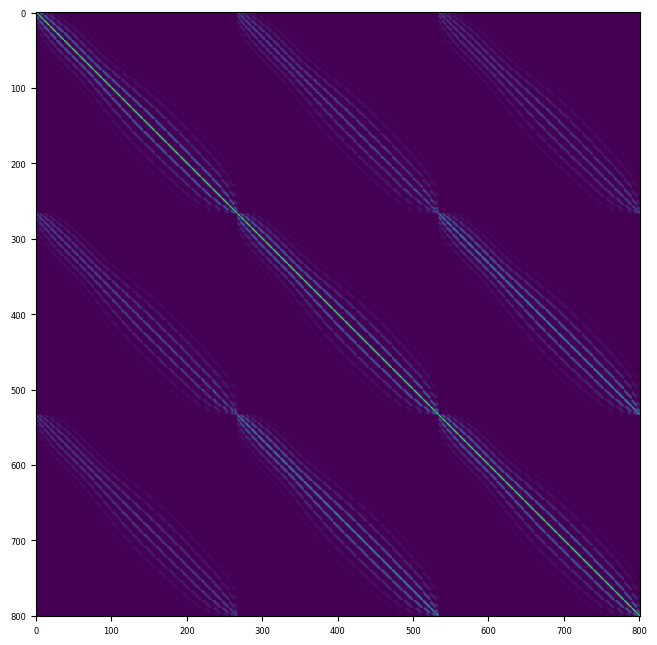

In [63]:
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(covmat_coarse.as_2d)

In [64]:
pp_coarse3d[['kh', 'kv', 'sy', 'ss']] = 86.4, 8.64, 0.2, 0.00001

In [65]:
pp_coarse3d

,name,x,y,z,zone,val,layer,kh,kv,sy,ss
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1,86.4,8.64,0.2,0.00001
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1,86.4,8.64,0.2,0.00001
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1,86.4,8.64,0.2,0.00001
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1,86.4,8.64,0.2,0.00001
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1,86.4,8.64,0.2,0.00001
...,...,...,...,...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3,86.4,8.64,0.2,0.00001
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3,86.4,8.64,0.2,0.00001
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3,86.4,8.64,0.2,0.00001
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3,86.4,8.64,0.2,0.00001


In [66]:
pp_coarse3d.to_csv(os.path.join(preproc_ws, 'pp3d_coarse.dat'), index=False, sep='\t')

## Setup parameterization for 3D elements (K, storage, porosity)

In [67]:
# Write generic template
with open(os.path.join(preproc_ws, 'gen_mf_array.tpl'), 'a') as f:
    f.write('$#p prop_mf.write_in_sequence(format="(1x,1pg18.11)")')

In [68]:
def write_script(filename, lines):

    with open(filename, 'a') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

Calculate kriging factors (porosity not included yet):

In [69]:
write_script(os.path.join(preproc_ws, 'plproc.dat'), [
f'''
### Read model grid ###
cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb,                  &
                            dimensions=2,                             &
                            slist_layer_idomain=idomain1;  layer=1,   &
                            slist_layer_idomain=idomain2;  layer=2,   &
                            slist_layer_idomain=idomain3;  layer=3)



### Read 3D pilot-points file ###
cl_pp = read_list_file(file=pp3d_coarse.dat,               &
                       id_type=character,                  &
                       dimensions=2,                       &
                       skiplines=1,                        &
                       slist=zone; col=5,                  &
                       slist=lyr; col=7,                   &
                       plist=kh_pp; col=8,                 &
                       plist=kv_pp; col=9,                 &
                       plist=sy_pp; col=10,                &
                       plist=ss_pp; col=11)


### Calculate kriging factors for each layer ###
calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp;select=(lyr==1), file=factors_pp_lyr1.dat)

calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp;select=(lyr==2), file=factors_pp_lyr2.dat)

calc_kriging_factors_auto_2d(target_clist=cl_mf, source_clist=cl_pp;select=(lyr==3), file=factors_pp_lyr3.dat)

### Write to template file ###
prop_mf=new_plist(reference_clist=cl_mf,value=1.0)

###   Horizontal K   ###
### Write kh layer 1 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k_layer1.txt)

### Write kh layer 2 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k_layer2.txt)

### Write kh layer 3 ###
prop_mf=86.4
prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k_layer3.txt)


###    Vertical K    ###
### Write kv layer 1 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k33_layer1.txt)

### Write kv layer 2 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k33_layer2.txt)

### Write kv layer 3 ###
prop_mf=8.64
prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.npf_k33_layer3.txt)



###      STORAGE     ###
###        sy        ###
### Write sy layer 1 ###
prop_mf=0.2
prop_mf=sy_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.sto_sy_layer1.txt)


###        ss        ###
### Write ss layer 2 ###
prop_mf=0.000001
prop_mf=ss_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.sto_ss_layer2.txt)

### Write ss layer 3 ###
prop_mf=0.000001
prop_mf=ss_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='log')
write_model_input_file(template_file=gen_mf_array.tpl, &
    model_input_file=../model/{ml_name}.sto_ss_layer3.txt)
'''
])

In [70]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions...
> cl_pp=read_list_file(file=pp3d_coarse.dat,id_type=character,dimension...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
> calc_kriging_factors_auto_2d(target_clist=cl_mf,source_clist=cl_pp;se...
> prop_mf=new_plist(reference_clist=cl_mf,value=1.0)
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_us

Comment out kriging factors:

In [71]:
def replace_in_file(path, input_file, original_str, replacement_str):
    # Read in the file
    with open(os.path.join(path, input_file), 'r') as file :
        filedata = file.read()

    # Replace the target string
    filedata = filedata.replace(original_str, replacement_str)

    # Write the file out again
    with open(os.path.join(path, input_file), 'w') as file:
        file.write(filedata)

In [72]:
# Comment out kriging factors
replace_in_file(preproc_ws, 'plproc.dat', 'calc_kriging_factors', '#calc_kriging_factors')

In [73]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions...
> cl_pp=read_list_file(file=pp3d_coarse.dat,id_type=character,dimension...
> prop_mf=new_plist(reference_clist=cl_mf,value=1.0)
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr2.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=86.4
> prop_mf=kh_pp.krige_using_file(file='factors_pp_lyr3.dat',transform='...
> write_model_input_file(template_file=gen_mf_array.tpl,model_input_fil...
> prop_mf=8.64
> prop_mf=kv_pp.krige_using_file(file='factors_pp_lyr1.dat',transform='...
> write_m

### Write template file

In [74]:
import copy
pp_coarse3d_tpl = copy.deepcopy(pp_coarse3d)

In [75]:
pp_coarse3d_tpl

,name,x,y,z,zone,val,layer,kh,kv,sy,ss
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1,86.4,8.64,0.2,0.00001
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1,86.4,8.64,0.2,0.00001
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1,86.4,8.64,0.2,0.00001
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1,86.4,8.64,0.2,0.00001
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1,86.4,8.64,0.2,0.00001
...,...,...,...,...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3,86.4,8.64,0.2,0.00001
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3,86.4,8.64,0.2,0.00001
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3,86.4,8.64,0.2,0.00001
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3,86.4,8.64,0.2,0.00001


In [76]:
pp_coarse3d_tpl['kh'] = [f'$kh{r.layer}pp{i + 1:03d}$' for i,r in pp_coarse3d_tpl.iterrows()]
pp_coarse3d_tpl['kv'] = [f'$kv{r.layer}pp{i + 1:03d}$' for i,r in pp_coarse3d_tpl.iterrows()] 
pp_coarse3d_tpl['sy'] = [f'$sy{r.layer}pp{i + 1:03d}$' for i,r in pp_coarse3d_tpl.iterrows()]
pp_coarse3d_tpl['ss'] = [f'$ss{r.layer}pp{i + 1:03d}$' for i,r in pp_coarse3d_tpl.iterrows()]

In [77]:
pp_coarse3d_tpl

,name,x,y,z,zone,val,layer,kh,kv,sy,ss
0,ppc0000,426900.0,6654800.0,129.505047,1,1,1,$kh1pp001$,$kv1pp001$,$sy1pp001$,$ss1pp001$
1,ppc0001,426900.0,6654830.0,130.317146,1,1,1,$kh1pp002$,$kv1pp002$,$sy1pp002$,$ss1pp002$
2,ppc0002,426900.0,6654860.0,131.046848,1,1,1,$kh1pp003$,$kv1pp003$,$sy1pp003$,$ss1pp003$
3,ppc0003,426900.0,6654890.0,131.926449,1,1,1,$kh1pp004$,$kv1pp004$,$sy1pp004$,$ss1pp004$
4,ppc0004,426930.0,6654770.0,129.346699,1,1,1,$kh1pp005$,$kv1pp005$,$sy1pp005$,$ss1pp005$
...,...,...,...,...,...,...,...,...,...,...,...
796,ppc0796,427560.0,6655190.0,136.406105,1,1,3,$kh3pp797$,$kv3pp797$,$sy3pp797$,$ss3pp797$
797,ppc0797,427590.0,6655100.0,135.688904,1,1,3,$kh3pp798$,$kv3pp798$,$sy3pp798$,$ss3pp798$
798,ppc0798,427590.0,6655130.0,136.154449,1,1,3,$kh3pp799$,$kv3pp799$,$sy3pp799$,$ss3pp799$
799,ppc0799,427590.0,6655160.0,136.808502,1,1,3,$kh3pp800$,$kv3pp800$,$sy3pp800$,$ss3pp800$


In [78]:
pp_coarse3d_tpl.to_csv(os.path.join(template_ws, 'pp3d_coarse.tpl'), index=False, sep='\t')

In [79]:
def line_prepender(filename, line):
    with open(filename, 'r+') as f:
        content = f.read()
        f.seek(0, 0)
        f.write(line.rstrip('\r\n') + '\n' + content)

In [80]:
line_prepender(os.path.join(template_ws, 'pp3d_coarse.tpl'), 'ptf $')

## Setup parameterization for SFR
Setup pilot points for linear boundary conditions General Head Boundaries (GHBs) and Creek Örbäcken (SFR), starting with SFR:

In [81]:
segfile = pd.read_csv(os.path.join(preproc_ws, 'sfr_segfile.dat'), sep='\t', names=['x', 'y', 'seg'])
display(segfile)

,x,y,seg
0,426924.228,6654927.297,r1s1
1,426927.764,6654930.833,r2s1
2,426931.299,6654927.297,r3s1
3,426934.835,6654930.833,r4s1
4,426938.370,6654927.297,r5s1
...,...,...,...
260,427610.122,6655125.287,r261s1
261,427613.657,6655128.823,r262s1
262,427617.193,6655132.358,r263s1
263,427620.729,6655128.823,r264s1


Fix the segments. This should probably be done in a better way and perhaps changed after the first round of history matching to get a better representation of stream reaches. This solution is just to make things work.

In [82]:
def largest_divisor(n):
    a = 1
    for i in range(2, n):
        if n % i == 0:
            a = i
    return a

In [83]:
nseg = largest_divisor(len(segfile))
#nseg = largest_divisor(nseg) # divide again to reduce the amount of pps from 135 to 45 (perhaps a stupid move)
print(nseg)

53


In [84]:
rows_per_seg = int(len(segfile) / nseg)
print(rows_per_seg)

5


In [85]:
for i in range(nseg):
    segfile.loc[(i * rows_per_seg):((i + 1) * rows_per_seg), ('seg')] = f's{i + 1}'

In [86]:
segfile

,x,y,seg
0,426924.228,6654927.297,s1
1,426927.764,6654930.833,s1
2,426931.299,6654927.297,s1
3,426934.835,6654930.833,s1
4,426938.370,6654927.297,s1
...,...,...,...
260,427610.122,6655125.287,s53
261,427613.657,6655128.823,s53
262,427617.193,6655132.358,s53
263,427620.729,6655128.823,s53


Rewrite seglist:

In [87]:
segfile.to_csv(
    os.path.join(preproc_ws, 'sfr_segfile.dat'),
    header=None,
    index=False,
    sep='\t',
    float_format='%.3f'
)

In [88]:
write_script(os.path.join(preproc_ws, 'plproc_seglist_temp.dat'), [
f'''
### Read model grid ###

cl_mf = read_mf6_grid_specs(  &
    file=../model/{ml_name}.disv.grb,  &
    dimensions=3,             & # Note 3D in this case
    slist_layernum = layer,   &
    slist_idomain = idomain   &
    )


### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)

### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=5.0)

### Write reports (pps will be constructed based on theses reports) ###
cl_sfr_pp.report_dependent_lists(file='report_sfr_seglist.dat')
'''
])

In [89]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_seglist_temp.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_seglist_temp.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions...
> sl_sfr=read_segfile(file="sfr_segfile.dat",protocol=table)
> cl_sfr_pp=create_clist_from_seglist(seglist=sl_sfr,linkage_type=endpo...
> cl_sfr_pp.report_dependent_lists(file='report_sfr_seglist.dat')
 
End of file: no more commands to process.



In [90]:
sfr_pps = pd.read_csv(os.path.join(preproc_ws, 'report_sfr_seglist.dat'), skiprows=[0, 1, 2])

In [91]:
sfr_pps

,Index Int_ID X-coord Y-coord
0,1 1 426924.228 6654927.297
1,2 2 426938.370 6654927.297
2,3 3 426941.906 6654930.833
3,4 4 426956.048 6654930.833
4,5 5 426973.726 6654934.368
...,...
64,65 65 427574.767 6655125.287
65,66 66 427588.909 6655125.287
66,67 67 427606.586 6655128.823
67,68 68 427610.122 6655125.287


In [92]:
sfr_pps.columns = sfr_pps.columns.str.replace(r'\ (?= *?\ )', '')

In [93]:
sfr_pps.iloc[:,0] = sfr_pps.iloc[:,0].str.replace(r'\ (?= *?\ )', '')

In [94]:
sfr_pps[['Index', 'Int_ID', 'X-coord', 'Y-coord']] = sfr_pps['Index Int_ID X-coord Y-coord'].str.split(' ', 3, expand=True)

In [95]:
sfr_pps['cond'] = 86.4

In [96]:
sfr_pps.rename(columns={'Int_ID': 'ppid', 'X-coord': 'x', 'Y-coord': 'y'}, inplace=True)

In [97]:
sfr_pps = sfr_pps[['ppid', 'x', 'y', 'cond']]

In [98]:
display(sfr_pps)

,ppid,x,y,cond
0,1,426924.228,6654927.297,86.4
1,2,426938.370,6654927.297,86.4
2,3,426941.906,6654930.833,86.4
3,4,426956.048,6654930.833,86.4
4,5,426973.726,6654934.368,86.4
...,...,...,...,...
64,65,427574.767,6655125.287,86.4
65,66,427588.909,6655125.287,86.4
66,67,427606.586,6655128.823,86.4
67,68,427610.122,6655125.287,86.4


In [99]:
sfr_pps.to_csv(
    os.path.join(preproc_ws, 'sfrpp.dat'),
    index=False,
    sep='\t',
)

#### Parameterize the INFLOW parameter of reach 1

In [100]:
sfr_pkgdatafile = f'{ml_name}.sfr_packagedata.txt'
shutil.copyfile(os.path.join(model_ws, sfr_pkgdatafile), os.path.join(preproc_ws, sfr_pkgdatafile))

'..\\temp_ml_param\\runmodel\\preproc\\hagfors_1.sfr_packagedata.txt'

In [101]:
os.rename(
    os.path.join(preproc_ws, f'{ml_name}.sfr_packagedata.txt'),
    os.path.join(preproc_ws, f'{ml_name}.sfr_packagedata.tpl')
)

In [102]:
sfr_perdatafile = f'{ml_name}.sfr_perioddata_1.txt'
shutil.copyfile(os.path.join(model_ws, sfr_perdatafile), os.path.join(template_ws, sfr_perdatafile))

'..\\temp_ml_param\\pest\\template\\hagfors_1.sfr_perioddata_1.txt'

In [103]:
os.rename(
    os.path.join(template_ws, f'{ml_name}.sfr_perioddata_1.txt'),
    os.path.join(template_ws, f'{ml_name}.sfr_perioddata_1.tpl')
)

In [104]:
line_prepender(os.path.join(template_ws, f'{ml_name}.sfr_perioddata_1.tpl'), 'ptf $')

In [105]:
with open(os.path.join(template_ws, f'{ml_name}.sfr_perioddata_1.tpl'), 'r') as file:
    sfr_perdata = file.readlines() #pestfile partial parameters

In [106]:
temp_row = sfr_perdata[2].split()
display(temp_row)

['1', 'inflow', '15000']

In [107]:
temp_row[-1] = '$sfr_inflow1$\n'
display(temp_row)

['1', 'inflow', '$sfr_inflow1$\n']

In [108]:
new_row = ' '.join(temp_row)
display(new_row)

'1 inflow $sfr_inflow1$\n'

In [109]:
sfr_perdata[2] = new_row

In [110]:
with open(os.path.join(template_ws, f'{ml_name}.sfr_perioddata_1.tpl'), 'w') as file:
    for line in sfr_perdata:
        file.write(line)

#### Write script

In [113]:
write_script(os.path.join(preproc_ws, 'plproc_sfr.dat'), [
f'''
### Read model grid ###

cl_mf = read_mf6_grid_specs(  &
    file=../model/{ml_name}.disv.grb,  &
    dimensions=3,             & # Note 3D in this case
    slist_layernum = layer,   &
    slist_idomain = idomain   &
    )


### Read Creek Örbäcken SFR seglist file ###
sl_sfr = read_segfile(file="sfr_segfile.dat", protocol=table)

### Create clist with sl_sfr as its base ###
cl_sfr_pp = create_clist_from_seglist(seglist=sl_sfr, linkage_type=endpoints, dist_thresh=5.0)

### Instruct PLPROC to read the *_cond.dat list file to obtain conductance values at  ###
### pilot points by inserting the following function into the PLPROC script.          ###
read_list_file(reference_clist='cl_sfr_pp', file='sfrpp.dat', skiprows=1, plist='pp_sfr_cond';column=4)

### Instruct PLPROC to build an SLIST of model drain cells to which interpolation must take place ###
sfr_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.sfr_packagedata.txt, model_type=mf6_disv, &
    list_col_start=2, keytext_start='top_of_file', keytext_end='end_of_file')

### Calculate interpolation factors to these model cells through linear interpolation ###
calc_linear_interp_factors(source_clist=cl_sfr_pp, target_clist=cl_mf;select=(sfr_cells.ne.0), file="factors_sfr_cells.dat", search_radius=50)

### Write ###
sfr_cond=new_plist(reference_clist=cl_mf,value=0.0)

sfr_cond=pp_sfr_cond.interp_using_file(file=factors_sfr_cells.dat, transform=log)

replace_cells_in_lists(                                 &
    old_file={ml_name}.sfr_packagedata.tpl,             &
    new_file=../model/{ml_name}.sfr_packagedata.txt,    &
    model_type=mf6_disv,                                &
    list_col_start=2,                                   &
    keytext_start='top_of_file',                        &
    keytext_end='bottom_of_file',                       &
    plist=sfr_cond;column=9;action='replace'            &
    )

# -- This is for our own interest.
cl_mf.report_dependent_lists(file='report-sfr.dat')

'''
])

In [114]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_sfr.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_sfr.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions...
> sl_sfr=read_segfile(file="sfr_segfile.dat",protocol=table)
> cl_sfr_pp=create_clist_from_seglist(seglist=sl_sfr,linkage_type=endpo...
> read_list_file(reference_clist='cl_sfr_pp',file='sfrpp.dat',skiprows=...
> sfr_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.sfr_packa...
> calc_linear_interp_factors(source_clist=cl_sfr_pp,target_clist=cl_mf;...
> sfr_cond=new_plist(reference_clist=cl_mf,value=0.0)
> sfr_cond=pp_sfr_cond.interp_using_file(file=factors_sfr_cells.dat,tra...
> replace_cells_in_lists(old_file=hagfors_1.sfr_packagedata.tpl,new_fil...
> cl_mf.report_dependent_lists(file='report-sfr.dat')
 
End of file: no more commands to process.



In [115]:
# Comment out kriging factors
replace_in_file(preproc_ws, 'plproc_sfr.dat', 'calc_linear_interp', '#calc_linear_interp')

Construct template file:

In [116]:
sfr_pps_tpl = copy.deepcopy(sfr_pps)

In [117]:
sfr_pps_tpl['cond'] = ['$sfrpp{:03d}$'.format(i) for i in range(1, len(sfr_pps_tpl) + 1)] 

In [118]:
sfr_pps_tpl.to_csv(os.path.join(template_ws, 'sfrpp.tpl'), index=False, sep='\t')

In [119]:
line_prepender(os.path.join(template_ws, 'sfrpp.tpl'), 'ptf $')

#### Setup SFR covariance matrix

In [120]:
sfr_pps['zone'] = 1

<ipython-input-120-18508e5e351e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sfr_pps['zone'] = 1


In [121]:
sfr_pps = sfr_pps[['ppid', 'x', 'y', 'zone', 'cond']]

In [122]:
sfr_pps.to_csv( # Essentially a copy of sfrpp.dat but without column headers
    os.path.join(preproc_ws, 'mksfrpp.dat'),
    index=False,
    header=False,
    sep='\t',
)

In [123]:
# run MKPPSTAT
run.run_process(
    'mkppstat',
    path=preproc_ws,
    commands=['mksfrpp.dat', '10', '1.5', 'sfrppstat.dat']
)

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 69 pilot points read from pilot points file mksfrpp.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file sfrppstat.dat written ok
 



In [124]:
# run PPCOV_SVA - pilot point covariance - spatially varying anisotropy
run.run_process(
    'ppcov_sva',
    path=preproc_ws,
    commands=['sfrppstat.dat', 'y', 0, 'x',  'cov_sfr.mat', '']
)

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 69 pilot points read from pilot points file sfrppstat.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter name (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov_sfr.mat written ok.



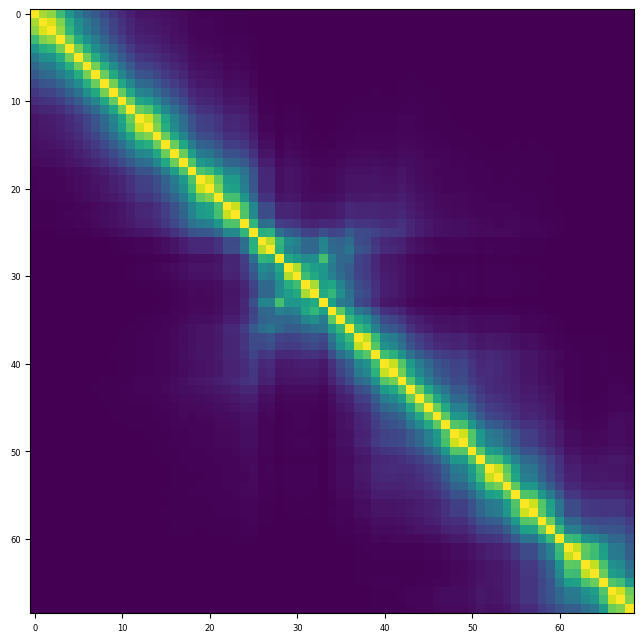

In [125]:
covmat_sfr = pyemu.Cov.from_ascii(os.path.join(preproc_ws, "cov_sfr.mat"))
plt.figure(figsize=(8, 8), dpi=100)
plt.imshow(covmat_sfr.as_2d)

#### Visualize SFR pps

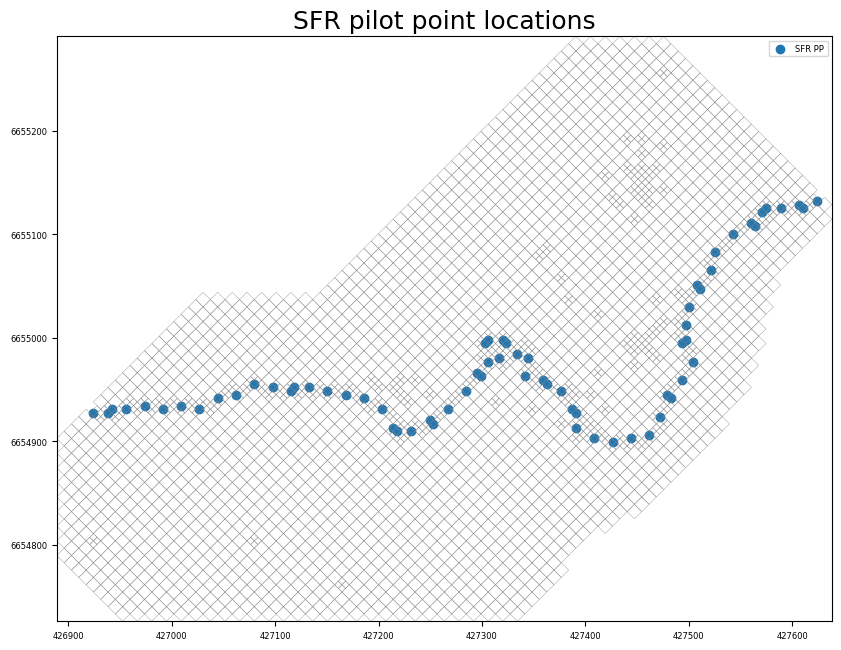

In [126]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('SFR pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

plt.scatter([float(i) for i in sfr_pps.x.values], [float(i) for i in sfr_pps.y.values], label='SFR PP')

plt.legend()
plt.show()

### GHB using pilot points

Copy the file and make an "template" of an `old_file` (is this really a template in a PEST context?)

In [127]:
ghb_file = f'{ml_name}.ghb_stress_period_data_1.txt'
shutil.copyfile(os.path.join(model_ws, ghb_file), os.path.join(preproc_ws, ghb_file))

'..\\temp_ml_param\\runmodel\\preproc\\hagfors_1.ghb_stress_period_data_1.txt'

In [128]:
os.rename(
    os.path.join(preproc_ws, f'{ml_name}.ghb_stress_period_data_1.txt'),
    os.path.join(preproc_ws, f'{ml_name}.ghb_stress_period_data_1.tpl')
)

In [129]:
write_script(os.path.join(preproc_ws, 'plproc_ghb.dat'), [
f'''
# -- We read the MODFLOW 6 binary grid file. We read it as a 2D file.

cl_mf = read_mf6_grid_specs(file=../model/{ml_name}.disv.grb, &
                              dimensions=3,             &
                              slist_layernum = layer,   &
                              slist_idomain  = idomain)

# -- We now build an SLIST of drain cells to which we want interpolation to take place.

ghb_red_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='top_of_file', keytext_end='2387  ghb_orange')
    
ghb_orange_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2387  ghb_red', keytext_end='2792  ghb_yellow')

ghb_yellow_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2800  ghb_orange', keytext_end='2802  ghb_limegreen')

ghb_limegreen_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='3090  ghb_yellow', keytext_end='1  ghb_royalblue')

ghb_royalblue_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='3057  ghb_limegreen', keytext_end='1  ghb_blueviolet')

ghb_blueviolet_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='2802  ghb_royalblue', keytext_end='316  ghb_magenta')

ghb_magenta_cells = cl_mf.find_cells_in_lists(file=../model/{ml_name}.ghb_stress_period_data_1.txt, model_type=mf6_disv, &
    list_col_start=1, keytext_start='316  ghb_blueviolet', keytext_end='end_of_file')

# -- We next read the pilot points file and pilot point locations and values.

cl_pp = read_list_file(file='ghbpp.dat',                                          &
                       id_type='character',                                       &
                       dimensions=2,                                              &
                       skiprows=1,                                                &
                       plist='ghbcond_pp';column=4)

# -- Initialize the drain conductivity PLIST
ghbcond_mf=new_plist(reference_clist=cl_mf,value=0.0)


# -- We now interpolate from pilot points to the drain conductances.
#    We use inverse power of distance; but any interpolation method could be used.

ghbcond_mf(select=((ghb_red_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20) # Perhaps too large?

ghbcond_mf(select=((ghb_orange_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=((ghb_yellow_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=((ghb_limegreen_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=((ghb_royalblue_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=((ghb_blueviolet_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

ghbcond_mf(select=((ghb_magenta_cells.ne.0)&&(layer.eq.1)))=ghbcond_pp.ivd_interpolate_2d( &
                                        transform='log',                          &
                                        inv_power=2.0,                            &
                                        min_points=2,                             &
                                        max_points=20,                            &
                                        search_radius=1.0e20)

# -- A new model input file is written.

replace_cells_in_lists(old_file={ml_name}.ghb_stress_period_data_1.tpl,               &
                       new_file=../model/{ml_name}.ghb_stress_period_data_1.txt,      &
                       model_type=mf6_disv,                                       &
                       list_col_start=1,                                          &
                       keytext_start='top_of_file',                               &
                       keytext_end='bottom_of_file',                              &
                       plist=ghbcond_mf;column=4;action='replace')

# -- This is for our own interest.
#cl_mf6.report_dependent_lists(file='report-ghb.dat')
'''
])

In [130]:
# run PLPROC
run.run_process(
    'plproc',
    path=preproc_ws,
    commands=['plproc_ghb.dat']
)


PLPROC Version 3.00. Watermark Numerical Computing.
 
Enter name of PLPROC script file:  
Reading and storing contents of PLPROC script file plproc_ghb.dat...
Processing commands in PLPROC script file...
 
> cl_mf=read_mf6_grid_specs(file=../model/hagfors_1.disv.grb,dimensions...
> ghb_red_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.ghb_s...
> ghb_orange_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.gh...
> ghb_yellow_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.gh...
> ghb_limegreen_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1...
> ghb_royalblue_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1...
> ghb_blueviolet_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_...
> ghb_magenta_cells=cl_mf.find_cells_in_lists(file=../model/hagfors_1.g...
> cl_pp=read_list_file(file='ghbpp.dat',id_type='character',dimensions=...
> ghbcond_mf=new_plist(reference_clist=cl_mf,value=0.0)
> ghbcond_mf(select=((ghb_red_cells.ne.0)&&(layer.eq.1)))=ghbc

#### GHB covmat

In [131]:
ghbpp_df = pd.read_csv(os.path.join(preproc_ws, 'ghbpp.dat'), sep='\t')

In [132]:
ghbpp_df['zone'] = 1

In [133]:
ghbpp_df = ghbpp_df[['ppid','x', 'y', 'zone', 'cond', 'bnames']]

In [134]:
# Create one pp derivative of each ghb boundname
for bname in ghbpp_df.bnames.unique():
    ghbpp_df.loc[ghbpp_df['bnames'] == bname].to_csv(
        os.path.join(preproc_ws, f'mkghb{bname}pp.dat'),
        index=False,
        header=False,
        sep='\t',
    )

In [135]:
for file in os.listdir(preproc_ws):
    if 'mkghb' in file:
        run.run_process(
            'mkppstat',
            path=preproc_ws,
            commands=[file, '10', '1.5', f'{file[2:-4]}_stat.dat']
        )

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 22 pilot points read from pilot points file mkghbbluevioletpp.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ghbbluevioletpp_stat.dat written ok
 

 
 Program MKPPSTAT writes a pilot points statistical specification file based 
   on a pilot points file using local pilot point density to set local 
   variogram range.
 
 Enter name of pilot points file:   - data for 8 pilot points read from pilot points file mkghblimegreenpp.dat
 
 Enter no. of pilot points to compute local ave. pp. sepn.:  Enter factor of ave. separation for local variogram "a" value: 
 Enter name for pilot point statistical spec. file:  - file ghblimegreenpp_

In [136]:
for file in os.listdir(preproc_ws):
    if 'ghb' in file and '_stat.dat' in file:
        filename = f'cov_{file[:6]}.mat'
        run.run_process(
            'ppcov_sva',
            path=preproc_ws,
            commands=[file, 'y', 1, 'x',  filename, '']
        )

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 22 pilot points read from pilot points file 
    ghbbluevioletpp_stat.dat
 
 Enter minimum allowable separation for points in same zone: 
 Is overall variogram spherical, exponential or Gaussian? [s/x/g]: 
 Enter name for output matrix file:  Enter pilot point prefix for parameter name (<Enter> if none): 
 Filling covariance matrix....
 Using SVD to assure positive definiteness of matrix....
 - file cov_ghbblu.mat written ok.

 
 Program PP2COV_SVA creates a covariance matrix file for pilot point 
   parameters where geostatistical properties are pilot-point-specific.
 
 Enter name of pilot points statistical specs file:  Skip a line at the top of this file?  [y/n]:   - data for 8 pilot points read from pilot points file 
    ghblime

#### Visualize GHB pps

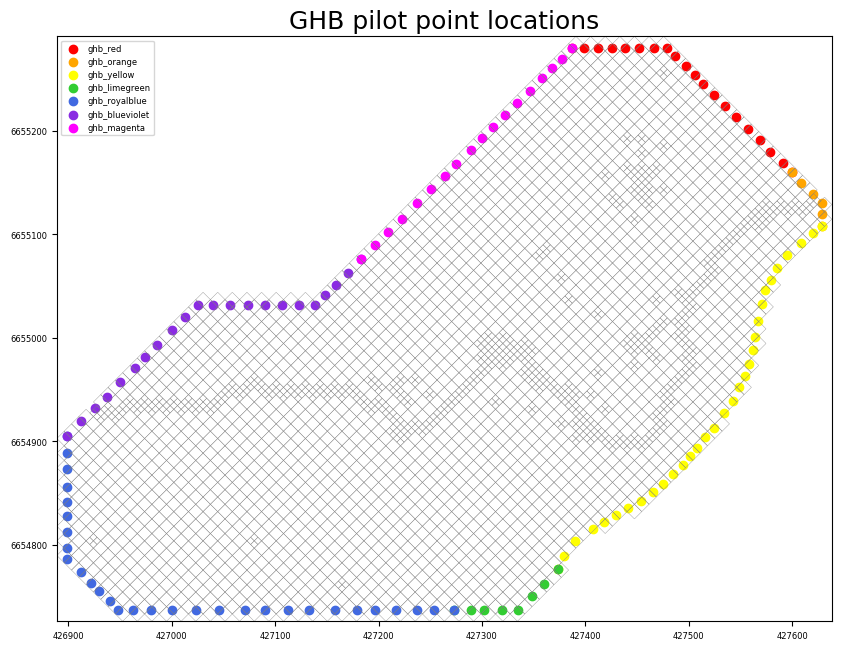

In [137]:
fig = plt.figure(figsize=(10, 10), dpi=100)
ax = fig.add_subplot(1, 1, 1, aspect='equal')
plt.ticklabel_format(axis='both', style='plain', useOffset=False) #Show coordinates
ax.set_title('GHB pilot point locations', fontsize=18)

mapview = flopy.plot.PlotMapView(gwf, layer=0)
linecollection = mapview.plot_grid(lw=0.25)

for bname in ghbpp_df['bnames'].unique():
    df = ghbpp_df.loc[ghbpp_df['bnames'] == bname]
    x = [float(i) for i in df.x.values]
    y = [float(i) for i in df.y.values]
    
    plt.scatter(x, y, color=bname, label=f'ghb_{bname}')

plt.legend()
plt.show()

## Parameterize LUMPREM models

Parameters to be adjusted through history-matching are:


| parameter | default | initial | upper bound | lower bound |
| --------- |--------:|--------:|-------------| ------------|
| maxvol    | 0.5     | 0.2     | 1           | 0.01        |
| rdelay    | 5       | 5       | 10          | 1           |
| mdelay    | 1       | 1       | 5           | 0           |
| Ks        | 0.1     | 86.4    | 864.0       | 0.000864    |
| m         | 0.5     | 1.0     | 2.0         | 0.01        |
| l         | 0.5     | 0.5     | 1.0         | 0.0         |
| mflowmax  | 0.1     | 0.1     | 0.2         | 0.01        |
| f         | 0.5     | 0.5     | 0.9         | 0.01        |
| γ         | 1.0     | 1.0     | 10.0        | 0.01        |

- *maxvol* The volume of the soil moisture store.
- *rdelay* Delay, in days, between water draining from the soil moisture store.
- *mdelay* Delay, in days, between water leaving the soil moisture store.
- *Ks* Hydraulic conductivity (meters per day). Initial: 86.4 (0.001 m/s)
- *m* A parameter determining the shape of the drainage rate vs. stored water relationship.
- *l* A pore-connectivity parameter (estimated by Mualem, 1976, to be about 0.5 for many soils).
- *mflowmax* Maximum macropore recharge allowed per day.
- *f* Crop factor.
- *γ* A parameter determining the shape of the evaporation rate vs. stored water relationship.

In [138]:
def parameterize_lr_model(lr_template_file, lr_ml_name):
    # Read in the file
    with open(os.path.join(template_ws, lr_template_file), 'r') as file:
        lines = file.readlines()

    # Replace the target string
    lines[2] = f'$maxvol_{lr_ml_name}$  0 \n' #earth properties maxvolume & irrigvolfrac
    lines[3] = f'$rdelay_{lr_ml_name}$  $mdelay_{lr_ml_name}$ \n' #earth properties delay factors
    lines[4] = f'$ks_{lr_ml_name}$  $m_{lr_ml_name}$  $l_{lr_ml_name}$  $mfmax_{lr_ml_name}$  \n' #earth properties factors
    lines[24] = f'$crfac_{lr_ml_name}$  $gamma_{lr_ml_name}$  \n' #crop factor & gamma

    # Write the file out again
    with open(os.path.join(template_ws, lr_template_file), 'w') as file:
        for line in lines:
            file.write(line)

Parameterize recharge model:

In [139]:
parameterize_lr_model('lr_lu1.tpl', 'lu1')

Parameterize GHB models:

In [157]:
for file in os.listdir(template_ws):
    if 'lr_' in file and 'lu1' not in file:
        parameterize_lr_model(file, file[3:][:3])

Done.

## Build partial PEST control file using TPL2PST

Write tpl2pst script:

In [158]:
write_script(os.path.join(template_ws, 'tpl2pst.in'), [
f'''
# An example TPL2PST input file

start template_file
  template_file     = pp3d_coarse.tpl
  model_input_file  = pp3d_coarse.dat
  transform         = log
  value             = 1.0
  lower_bound       = 0.1     
  upper_bound       = 10
  pargroup          = changethis
end template_file

start template_file
  template_file     = sfrpp.tpl
  model_input_file  = sfrpp.dat
  transform         = log
  value             = 86.4
  lower_bound       = 0.000864     
  upper_bound       = 864.0
  pargroup          = sfrc
end template_file

start template_file
  template_file     = ghbpp.tpl
  model_input_file  = ghbpp.dat
  transform         = log
  value             = 86.4
  lower_bound       = 0.000864     
  upper_bound       = 864.0
  pargroup          = ghbc
end template_file

start template_file
  template_file     = hagfors_1.sfr_perioddata_1.tpl
  model_input_file  = hagfors_1.sfr_perioddata_1.txt
  transform         = log
  value             = 15000
  lower_bound       = 100     
  upper_bound       = 40000
  pargroup          = sfrinfl1
end template_file

start template_file
  template_file     = lr_lu1.tpl 
  model_input_file  = lr_lu1.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = rch
end template_file

start template_file
  template_file     = lr_red.tpl 
  model_input_file  = lr_red.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbred
end template_file

start template_file
  template_file     = lr_orange.tpl 
  model_input_file  = lr_orange.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbora
end template_file

start template_file
  template_file     = lr_yellow.tpl 
  model_input_file  = lr_yellow.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbyel
end template_file

start template_file
  template_file     = lr_limegreen.tpl 
  model_input_file  = lr_limegreen.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghblim
end template_file

start template_file
  template_file     = lr_royalblue.tpl 
  model_input_file  = lr_royalblue.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbroy
end template_file

start template_file
  template_file     = lr_blueviolet.tpl 
  model_input_file  = lr_blueviolet.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbblu
end template_file

start template_file
  template_file     = lr_magenta.tpl 
  model_input_file  = lr_magenta.in
  transform         = log
  value             = 1 # change this
  lower_bound       = 0.1 # change this     
  upper_bound       = 10 # change this
  pargroup          = lrghbmag
end template_file
'''
])

In [159]:
# run TPL2PST
run.run_process(
    'tpl2pst',
    path=template_ws,
    commands=['tpl2pst.in', 'param.pst']
)


 TPL2PST Version 17.2. Watermark Numerical Computing.

 TPL2PST is run using the command:

     tpl2pst infile pestfile 

 where

     infile   is a TPL2PST input file, and
     pestfile is the partial PEST control file it must write.



running tpl2pst doesn't work for some reason. has to be run subprocess below:

In [160]:
import subprocess
p = subprocess.run(['tpl2pst', 'tpl2pst.in', 'param.pst'], cwd=template_ws, stdout=subprocess.PIPE, text=True)
for row in p.stdout.split('\n'):
    print(row)


 TPL2PST Version 17.2. Watermark Numerical Computing.
 - file tpl2pst.in read ok.

 - reading file pp3d_coarse.tpl...
 - 3204 params found in file pp3d_coarse.tpl.

 - reading file sfrpp.tpl...
 - 69 params found in file sfrpp.tpl.

 - reading file ghbpp.tpl...
 - 136 params found in file ghbpp.tpl.

 - reading file hagfors_1.sfr_perioddata_1.tpl...
 - 1 params found in file hagfors_1.sfr_perioddata_1.tpl.

 - reading file lr_lu1.tpl...
 - 9 params found in file lr_lu1.tpl.

 - reading file lr_red.tpl...
 - 9 params found in file lr_red.tpl.

 - reading file lr_orange.tpl...
 - 9 params found in file lr_orange.tpl.

 - reading file lr_yellow.tpl...
 - 9 params found in file lr_yellow.tpl.

 - reading file lr_limegreen.tpl...
 - 9 params found in file lr_limegreen.tpl.

 - reading file lr_royalblue.tpl...
 - 9 params found in file lr_royalblue.tpl.

 - reading file lr_blueviolet.tpl...
 - 9 params found in file lr_blueviolet.tpl.

 - reading file lr_magenta.tpl...
 - 9 params found in 

In [161]:
os.listdir(template_ws) # param.pst is now created

['ghbpp.tpl',
 'hagfors_1.sfr_perioddata_1.tpl',
 'lr_blueviolet.tpl',
 'lr_limegreen.tpl',
 'lr_lu1.tpl',
 'lr_magenta.tpl',
 'lr_orange.tpl',
 'lr_red.tpl',
 'lr_royalblue.tpl',
 'lr_yellow.tpl',
 'param.pst',
 'pp3d_coarse.tpl',
 'sfrpp.tpl',
 'tpl2pst.in']

### Make necessary changes to param.pst:

In [162]:
with open(os.path.join(template_ws, 'param.pst'), 'r') as file:
    pstfilep_param = file.readlines() #pestfile partial parameters

In [163]:
pstfilep_param

['pcf\n',
 '* control data\n',
 'restart estimation\n',
 '      3482         0        12         0         0\n',
 '   12  0    single  point\n',
 ' 10.0  -3.0  0.3  0.03  10  lamforgive\n',
 ' 10.0  10.0  0.001\n',
 ' 0.1\n',
 ' 50  0.005  4  4  0.005  4\n',
 ' 0  0  0\n',
 '* singular value decomposition\n',
 '1\n',
 '  5000  5e-7\n',
 '0\n',
 '* parameter groups\n',
 'changethis    relative   0.015   0.0  switch  2  parabolic\n',
 'sfrc          relative   0.015   0.0  switch  2  parabolic\n',
 'ghbc          relative   0.015   0.0  switch  2  parabolic\n',
 'sfrinfl1      relative   0.015   0.0  switch  2  parabolic\n',
 'rch           relative   0.015   0.0  switch  2  parabolic\n',
 'lrghbred      relative   0.015   0.0  switch  2  parabolic\n',
 'lrghbora      relative   0.015   0.0  switch  2  parabolic\n',
 'lrghbyel      relative   0.015   0.0  switch  2  parabolic\n',
 'lrghblim      relative   0.015   0.0  switch  2  parabolic\n',
 'lrghbroy      relative   0.015   0.0  swit

In [164]:
print('Relevant indices:') # print relevant indices of the pstfilep_param
print(pstfilep_param.index('* parameter groups\n'))
print(pstfilep_param.index('* parameter data\n'))
print(pstfilep_param.index('* observation groups\n'))

Relevant indices:
14
27
3510


### Change parameter data

Let's start by changing all the parameters marked with "changethis" (as suggested by calibration tutorial):

In [165]:
paramdata_start = pstfilep_param.index('* parameter data\n') + 1
paramdata_stop = pstfilep_param.index('* observation groups\n')

In [166]:
pardata_df = pd.DataFrame(pstfilep_param[paramdata_start:paramdata_stop]) # read df

In [167]:
pardata_df.iloc[:,0] = pardata_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '') # clean up data structure

In [168]:
pardata_cols = ['PARNME', 'PARTRANS', 'PARCHGLIM', 'PARVAL1', 'PARLBND', 'PARUBND', 'PARGP', 'SCALE', 'OFFSET']

In [169]:
pardata_df[pardata_cols] = pardata_df[0].str.split(' ', 9, expand=True) # add columns

In [170]:
pardata_df = pardata_df[pardata_cols] # remove redundant column
display(pardata_df) # view df

,PARNME,PARTRANS,PARCHGLIM,PARVAL1,PARLBND,PARUBND,PARGP,SCALE,OFFSET
0,kh1pp001,log,factor,1.000000,0.1000000,10.00000,changethis,1.0,0.0\n
1,kv1pp001,log,factor,1.000000,0.1000000,10.00000,changethis,1.0,0.0\n
2,sy1pp001,log,factor,1.000000,0.1000000,10.00000,changethis,1.0,0.0\n
3,ss1pp001,log,factor,1.000000,0.1000000,10.00000,changethis,1.0,0.0\n
4,kh1pp002,log,factor,1.000000,0.1000000,10.00000,changethis,1.0,0.0\n
...,...,...,...,...,...,...,...,...,...
3477,m_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n
3478,l_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n
3479,mfmax_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n
3480,crfac_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n


Sort the dataframe based on parameters (as suggested by calibration tutorial):

In [171]:
pardata_df = pardata_df.sort_values(['PARNME', 'PARGP']).reset_index(drop=True)

Assign new parameter groups (PARGP) for each type of parameter:

In [172]:
parnme_pargrp = [
    'ghbcblu', 'ghbclim', 'ghbcmag', 'ghbcora', 'ghbcred', 
    'ghbcroy','ghbcyel', 'kh1pp', 'kh2pp', 'kh3pp', 'kv1pp',
    'kv2pp', 'kv3pp', 'sfrpp', 'ss1pp', 'ss2pp', 'ss3pp',
    'sy1pp', 'sy2pp', 'sy3pp'
]

In [173]:
for i in parnme_pargrp:
    pardata_df.loc[pardata_df['PARNME'].str.contains(i), 'PARGP'] = i

In [174]:
pardata_df

,PARNME,PARTRANS,PARCHGLIM,PARVAL1,PARLBND,PARUBND,PARGP,SCALE,OFFSET
0,crfac_blu,log,factor,1.000000,0.1000000,10.00000,lrghbblu,1.0,0.0\n
1,crfac_lim,log,factor,1.000000,0.1000000,10.00000,lrghblim,1.0,0.0\n
2,crfac_lu1,log,factor,1.000000,0.1000000,10.00000,rch,1.0,0.0\n
3,crfac_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n
4,crfac_ora,log,factor,1.000000,0.1000000,10.00000,lrghbora,1.0,0.0\n
...,...,...,...,...,...,...,...,...,...
3477,sy3pp797,log,factor,1.000000,0.1000000,10.00000,sy3pp,1.0,0.0\n
3478,sy3pp798,log,factor,1.000000,0.1000000,10.00000,sy3pp,1.0,0.0\n
3479,sy3pp799,log,factor,1.000000,0.1000000,10.00000,sy3pp,1.0,0.0\n
3480,sy3pp800,log,factor,1.000000,0.1000000,10.00000,sy3pp,1.0,0.0\n


Assign new (initial) parameter value, lower and upper bounds for the non-linear pilot point parameters:

In [175]:
parval1 = {'kh': 86.4, 'kv': 8.64, 'sy': 0.2, 'ss': 0.000001}
parlbnd = {'kh': 8.64E-04, 'kv': 8.64E-05, 'sy': 0.05, 'ss': 0.00000001}
parubnd = {'kh': 864.0, 'kv': 864.0, 'sy': 0.35, 'ss': 0.001}

In [176]:
for d, col in zip([parval1, parlbnd, parubnd], ['PARVAL1', 'PARLBND', 'PARUBND']):
    for k,v in d.items():
        pardata_df.loc[pardata_df['PARGP'].str.contains(k), col] = v

In [177]:
display(pardata_df)

,PARNME,PARTRANS,PARCHGLIM,PARVAL1,PARLBND,PARUBND,PARGP,SCALE,OFFSET
0,crfac_blu,log,factor,1.000000,0.1000000,10.00000,lrghbblu,1.0,0.0\n
1,crfac_lim,log,factor,1.000000,0.1000000,10.00000,lrghblim,1.0,0.0\n
2,crfac_lu1,log,factor,1.000000,0.1000000,10.00000,rch,1.0,0.0\n
3,crfac_mag,log,factor,1.000000,0.1000000,10.00000,lrghbmag,1.0,0.0\n
4,crfac_ora,log,factor,1.000000,0.1000000,10.00000,lrghbora,1.0,0.0\n
...,...,...,...,...,...,...,...,...,...
3477,sy3pp797,log,factor,0.2,0.05,0.35,sy3pp,1.0,0.0\n
3478,sy3pp798,log,factor,0.2,0.05,0.35,sy3pp,1.0,0.0\n
3479,sy3pp799,log,factor,0.2,0.05,0.35,sy3pp,1.0,0.0\n
3480,sy3pp800,log,factor,0.2,0.05,0.35,sy3pp,1.0,0.0\n


Assign new (initial) parameter value, lower and upper bounds for the **lumprem** parameters:

Extract data from df to list:

In [ ]:
pardata_list = pardata_df.values.tolist()

In [ ]:
pardata_new = []
for i in pardata_list:
    pardata_new.append(' '.join(str(v) for v in i))

This is the old parameter data:

In [ ]:
display(pstfilep_param[paramdata_start:paramdata_stop])

Which will now be replaced by the new parameter data, which is this:

In [ ]:
display(pardata_new) # show list

Create a temporary copy of the original `pstfilep_param`:

In [ ]:
pstfilep_param_temp = pstfilep_param[:]

Replace the old parameter data with the changed pardata in the templist:

In [ ]:
for (index, replacement) in zip([i for i in range(paramdata_start, paramdata_stop)], pardata_new):
    pstfilep_param_temp[index] = replacement

The parameter data has now been replaced:

In [ ]:
display(pstfilep_param_temp)

### Change parameter groups

Get relevant indices:

In [ ]:
pargrp_start = pstfilep_param_temp.index('* parameter groups\n') + 1
pargrp_stop = pstfilep_param_temp.index('* parameter data\n')

Let's have a look at the current parameter grous config:

In [ ]:
pargrp_df = pd.DataFrame(pstfilep_param_temp[pargrp_start:pargrp_stop])
pargrp_df.iloc[:,0] = pargrp_df.iloc[:,0].str.replace(r'\ (?= *?\ )', '')
pargrp_cols = ['PARGPNME', 'INCTYP', 'DERINC', 'DERINCLB', 'FORCEN', 'DERINCMUL', 'DERMTHD']
pargrp_df[pargrp_cols] = pargrp_df[0].str.split(' ', 7, expand=True)
pargrp_df = pargrp_df[pargrp_cols]
display(pargrp_df)

Let's recreate this data structure (no need to use a dataframe):

In [ ]:
pargrp_new = [' '.join(str(v) for v in [i, 'relative', 0.015, 0.0, 'switch', 2, 'parabolic\n']) for i in pardata_df['PARGP'].unique()]
display(pargrp_new)

Make a new copy of the partial pestfile:

In [ ]:
pstfilep_param_new = pstfilep_param_temp[:]

Replace the old parameter groups with the changed pargp in the temp2list:

In [ ]:
pstfilep_param_new[pargrp_start:pargrp_stop] = pargrp_new

The parameter groups have now been changed:

In [ ]:
display(pstfilep_param_new)

### Change NPARGP (number of parameter groups)

This is the third column of the third index (number 3 below):

In [ ]:
pstfilep_param_new[3]

In [ ]:
temp_row = pstfilep_param_new[3].split()
display(temp_row)

In [ ]:
npargp = len(pardata_df['PARGP'].unique()) # number of parameter groups
print(npargp)

In [ ]:
temp_row[2] = str(npargp)
temp_row[-1] = '0\n'
display(temp_row)

In [ ]:
new_row = ' '.join(temp_row)
display(new_row)

In [ ]:
pstfilep_param_new[3] = new_row

In [ ]:
display(pstfilep_param_new)

### Write new partial pest parameter file:

In [ ]:
with open(os.path.join(template_ws, 'partial_param.pst'), 'w') as file:
    for line in pstfilep_param_new:
        file.write(line)

### Copy pestfile to pestdir

In [ ]:
partial_pestfile = 'partial_param.pst'
shutil.copyfile(os.path.join(template_ws, partial_pestfile), os.path.join(pest_ws, partial_pestfile))

In [ ]:
os.rename(
    os.path.join(pest_ws, 'partial_param.pst'),
    os.path.join(pest_ws, 'calib0.pst')
)

### Fix model input/output

In [ ]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'r') as file:
    pstfilep_calib = file.readlines() #pestfile partial parameters

Get index:

In [ ]:
ml_io_start = pstfilep_calib.index('* model input/output\n') + 1

In [ ]:
pstfilep_calib[ml_io_start:]

In [ ]:
prepend1, prepend2 = '.\\template\\', '..\\runmodel\\preproc\\'

In [ ]:
new_ml_io = []
for i in pstfilep_calib[ml_io_start:]:
    for string, j in zip([prepend1, prepend2], i.split()):
        new_ml_io.append(string + j)

In [ ]:
new_ml_io

In [ ]:
new_ml_io = [' '.join(i) for i in zip(new_ml_io[0::2], new_ml_io[1::2])]

In [ ]:
new_ml_io = [i+'\n' for i in new_ml_io]

In [ ]:
new_ml_io

In [ ]:
pstfilep_calib[ml_io_start:] = new_ml_io

Overwrite `calib0.pst`:

In [ ]:
with open(os.path.join(pest_ws, 'calib0.pst'), 'w') as file:
    for line in pstfilep_calib:
        file.write(line)

Parameters: kh, kx, sy, ss, sfrcond, ghbcond, lu1 lumprem recharge model (still tbd ghb lumprem models)

### END OF NOTEBOOK

---